In [12]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from tqdm import tqdm

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [14]:
data_flag = 'dermamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [15]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

BATCH_SIZE = 128

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)
valid_dataset = DataClass(split='val', transform=data_transform, download=download, size=64)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = data.DataLoader(dataset=valid_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=8)

Using downloaded and verified file: /home/tomek/.medmnist/dermamnist_64.npz
Using downloaded and verified file: /home/tomek/.medmnist/dermamnist_64.npz
Using downloaded and verified file: /home/tomek/.medmnist/dermamnist_64.npz


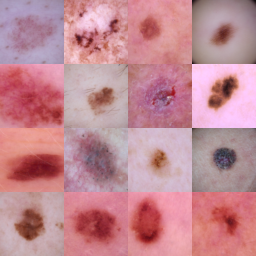

In [16]:
train_dataset.montage(4)

In [17]:
class MedModel(nn.Module):
    def __init__(self, num_labels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Get ResNet50 model with ImageNet weights
        self.model = models.resnet50(weights='IMAGENET1K_V2')
        # freeze convolution parameters
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        # Fully connected layer with num_labels classes
        self.model.fc = nn.Linear(num_ftrs, num_labels)
    def forward(self, x):
        return self.model(x)

In [18]:
model = MedModel(n_classes)
model = model.to(device)

model

MedModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
def accuracy(loader, loader_type):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze(1)
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} {loader_type} images: {100 * correct / total:.2f} %')

In [21]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[%d/{num_epochs}] loss: %.3f' %
          (epoch+1 ,  running_loss / len(train_dataset)))
    accuracy(train_loader, 'train')
    accuracy(val_loader, 'valid')
    running_loss = 0.0

print('Finished Training')

100%|██████████| 55/55 [00:32<00:00,  1.69it/s]

[1/10] loss: 0.009


Accuracy of the network on the 7007 train images: 71.10 %
Accuracy of the network on the 1003 valid images: 71.09 %


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]

[2/10] loss: 0.007


Accuracy of the network on the 7007 train images: 75.22 %
Accuracy of the network on the 1003 valid images: 72.68 %


100%|██████████| 55/55 [00:34<00:00,  1.60it/s]

[3/10] loss: 0.006


Accuracy of the network on the 7007 train images: 77.12 %
Accuracy of the network on the 1003 valid images: 73.38 %


100%|██████████| 55/55 [00:36<00:00,  1.49it/s]

[4/10] loss: 0.006


Accuracy of the network on the 7007 train images: 79.14 %
Accuracy of the network on the 1003 valid images: 72.88 %


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]

[5/10] loss: 0.005


Accuracy of the network on the 7007 train images: 79.71 %
Accuracy of the network on the 1003 valid images: 72.98 %


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]

[6/10] loss: 0.005


Accuracy of the network on the 7007 train images: 81.48 %
Accuracy of the network on the 1003 valid images: 72.98 %


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]

[7/10] loss: 0.005


KeyboardInterrupt: 

In [22]:
torch.save(model, 'real_trained_classifier.pth')